In [18]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

RESULTS_FILENAME = "real_data/decode_results2019_04_30_20_24_49.hdf5"

In [19]:
def cycle_from_style(scheme):
    return [color_dict["color"] for color_dict in plt.style.library[scheme]['axes.prop_cycle']]

#dim_colors = cycle_from_style("fivethirtyeight")
dim_colors = ["red", "coral", "gray", "black"]

def decoding_fix_axes(fig_width=10, fig_height=5, wpad_edge=0, wpad_mid=.1, hpad_edge=0, hpad_mid=.1):
    fig = plt.figure(figsize=(fig_width, fig_height))
    sq_width = (1 - 2*wpad_edge - 2*wpad_mid)/3
    sq_height = sq_width * fig_width/fig_height
    
    #top row
    ax1 = fig.add_axes((wpad_edge, hpad_edge + sq_height + hpad_mid, sq_width, sq_height))
    ax2 = fig.add_axes((wpad_edge + sq_width + wpad_mid, hpad_edge + sq_height + hpad_mid, sq_width, sq_height))
    ax3 = fig.add_axes((wpad_edge + 2*sq_width + 2*wpad_mid, hpad_edge + sq_height + hpad_mid, sq_width, sq_height))
    
    #bottom row
    ax4 = fig.add_axes((wpad_edge, hpad_edge, sq_width, sq_height))
    ax5 = fig.add_axes((wpad_edge + sq_width + wpad_mid, hpad_edge, sq_width, sq_height))
    ax6 = fig.add_axes((wpad_edge + 2*sq_width + 2*wpad_mid, hpad_edge, sq_width, sq_height))
    
    axes = (ax1, ax2, ax3, ax4, ax5, ax6)
    return axes

def scatter_r2_vals(r2_vals, T_pi_idx, dim_vals, offset_vals, min_val=None, max_val=None,
                    legend_both_cols=True, timestep=1, timestep_units="", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
           
    #calculate means across CV folds
    vals_mean = np.mean(r2_vals, axis=0)
    dca_mean = vals_mean[:, :, T_pi_idx + 2]
    pca_mean = vals_mean[:, :, 0]
    
    #set plot bounds
    if min_val is None or max_val is None:
        min_val = np.min(np.concatenate(( dca_mean, pca_mean )))
        max_val = np.max(np.concatenate(( dca_mean, pca_mean )))
    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    
    #set ticks
    ax.set_xticks([min_val, max_val])
    ax.set_xticklabels([min_val, max_val], fontsize=12)
    ax.set_yticks([min_val, max_val])
    ax.set_yticklabels([min_val, max_val], fontsize=12)
    
    #plot diagonal line
    t = np.linspace(min_val, max_val, 100)
    ax.plot(t, t, c="black", linestyle="--", zorder=0)
    
    #make scatter
    markers = ['x', '+', 'v', 's']
    for dim_idx in range(len(dim_vals)):
        for offset_idx in range(len(offset_vals)):
            x, y = pca_mean[dim_idx, offset_idx], dca_mean[dim_idx, offset_idx]
            ax.scatter(x, y, c=[dim_colors[dim_idx]], marker=markers[offset_idx], s=60)
            
    #make legend
    #only plot dim vals if we're supposed to
    if legend_both_cols:
        for dim_idx in range(len(dim_vals)):
            dim_str = "dim: " + str(dim_vals[dim_idx])
            ax.scatter(-1, -1, c=[dim_colors[dim_idx]], marker="o", label=dim_str, s=50)
        ncol = 2
    else:
        ncol = 1
    #always plot offset (lag) vals
    for offset_idx in range(len(offset_vals)):
        lag_str = "lag: " + str(offset_vals[offset_idx] * timestep) + " " + timestep_units
        ax.scatter(-1, -1, c="black", marker=markers[offset_idx], label=lag_str, s=50)  
    ax.legend(frameon=True, ncol=ncol, columnspacing=0.5,
              handletextpad=0, fontsize=9,
              loc="lower right", fancybox=True)

    #add labels/titles
    ax.set_xlabel("PCA $R^2$", fontsize=16, labelpad=-5)
    ax.set_ylabel("DCA $R^2$", fontsize=16, labelpad=0)
    
def plot_pi_vs_T(r2_vals, T_pi_vals, dim_vals, offset_idx=0, min_max_val=None,
                 legend=True, timestep=1, timestep_units="", ax=None):
    
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, 5))
       
    #calculate mean pct improvement accross CV folds
    sfa_mean = r2_vals[:, :, offset_idx, 1].mean(axis=0)
    dca_mean = r2_vals[:, :, offset_idx, 2:].mean(axis=0)
    pct_improvement_mean = (dca_mean - sfa_mean[:, np.newaxis]) / sfa_mean[:, np.newaxis]
    
    #set plot bounds
    if min_max_val is None:
        min_max_val = np.max(np.abs(pct_improvement_mean))
    ax.set_ylim([-min_max_val, min_max_val])
    
    #set ticks
    ax.set_yticks([-min_max_val, min_max_val])
    tick_str = str(int(min_max_val*100)) + "%"
    ax.set_yticklabels(["-" + tick_str, tick_str], fontsize=12)
    x_vals = T_pi_vals * timestep
    x_ticks = x_vals[1::2]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks.astype(np.int), fontsize=12)
    
    #plot zero line
    ax.axhline(0, c="black", linestyle="--", zorder=0)
    
    #plot data
    for dim_idx in range(len(dim_vals)):
        dim_str = "dim: " + str(dim_vals[dim_idx])
        ax.plot(x_vals, pct_improvement_mean[dim_idx],
                color=dim_colors[dim_idx],
                marker=".", markersize=10,
                label=dim_str)
        
    #make legend
    if legend:
        ax.legend(frameon=True, fontsize=9, loc="lower right", fancybox=True)
    
    #add labels/titles
    ax.set_xlabel("$T_{PI}$ (" + timestep_units + ")", fontsize=16, labelpad=0)
    ax.set_ylabel("improvement over SFA", fontsize=16, labelpad=0)

    


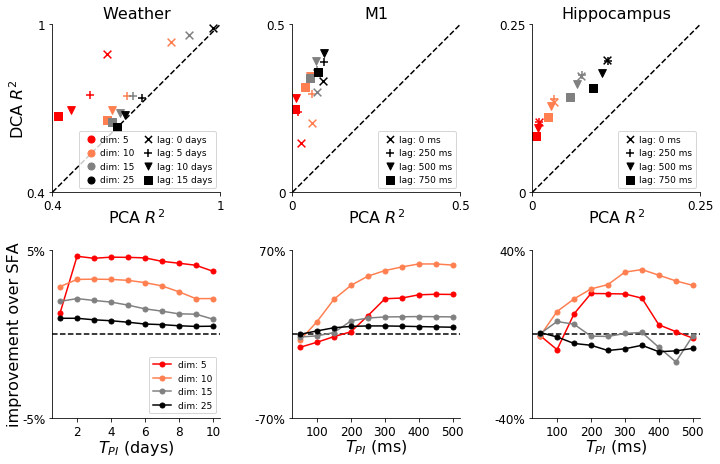

In [20]:
#load results
f = h5py.File(RESULTS_FILENAME, "r")

#create axes
ax1, ax2, ax3, ax4, ax5, ax6 = decoding_fix_axes(fig_width=10, fig_height=4, wpad_edge=0.05, wpad_mid=0.1, hpad_edge=0.05, hpad_mid=0.2)
axes_top = [ax1, ax2, ax3]
axes_bottom = [ax4, ax5, ax6]

#setup plot titles and window limits
dsets = ["weather", "m1", "hc"]
titles = {"hc": "Hippocampus", "m1": "M1", "weather": "Weather"}
#lower/upper limits for top row plots
min_max_vals_top = {"hc": (0, 0.25), "m1": (0, 0.5), "weather": (0.4, 1)}
#lower/upper limits (constrained to be the same) for bottom row plots
max_abs_vals_bottom = {"hc": 0.4, "m1": 0.7, "weather": 0.05}

for dset_idx in range(len(dsets)):
    #get top/bottom row's axes
    ax_top = axes_top[dset_idx]
    ax_bottom = axes_bottom[dset_idx]
    
    #get r2 results and metadata
    dset = dsets[dset_idx]
    r2_vals = f[dset]["results"][:]
    dim_vals = f[dset].attrs["dim_vals"]
    offset_vals = f[dset].attrs["offset_vals"]
    num_cv_folds = f[dset].attrs["num_cv_folds"]
    T_pi_vals = f[dset].attrs["T_pi_vals"]
    timestep = f[dset].attrs["timestep"]
    timestep_units = f[dset].attrs["timestep_units"]
    
    #plot r2 scatter in upper ax
    scatter_r2_vals(r2_vals, -1, dim_vals, offset_vals,
                    min_val=min_max_vals_top[dset][0], max_val=min_max_vals_top[dset][1],
                    legend_both_cols=(dset_idx == 0),
                    timestep=timestep, timestep_units=timestep_units,
                    ax=ax_top)
    ax_top.set_title(titles[dset], fontsize=16)
    
    #plot improvement over SFA in bottom ax
    plot_pi_vs_T(r2_vals, T_pi_vals, dim_vals,
                 min_max_val=max_abs_vals_bottom[dset],
                 legend=(dset_idx == 0),
                 timestep=timestep, timestep_units=timestep_units,
                 ax=ax_bottom)

for ax in axes_top + axes_bottom:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
for ax in axes_top[1:] + axes_bottom[1:]:
    ax.set_ylabel("")
    
#plt.savefig("figures/decode_results.pdf", bbox_inches="tight")
